 # **How Much Your Model's Accuracy is Sensible to Changes in the Dataset's Structure?**


For a variety of reasons, a machine learning (ML) practitioner may be exposed to dataset shift or loss of instances in his/her dataset. This set of experiments aims to show how intrinsically exposed the practitioner is to variations in accuracy, considering inherent characteristics of the dataset that are not revealed when traditional ML experiments are conducted. A deeper look will be taken into the geometric structure of some datasets, and a method to measure the practitioner's exposure to significant changes in his/her dataset will be proposed, called **accuracy degradation profile** (ADP).

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from holisticai.robustness.dataset_shift import accuracy_degradation_profile

from holisticai.utils.plots import (
                                    plot_graph,
                                    plot_highlight_test_set,
                                    plot_just_test_set,
                                    plot_ytest_ypred,
                                    plot_neighborhoods
                                    )


First, create your own 2D classification dataset for the experiments:

In [2]:
# Imports
from sklearn.datasets import make_blobs

# Generate synthetic data using make_blobs with closer centers
center_box = 2.5
X, y = make_blobs(n_samples=100, 
                  centers=2, 
                  n_features=2, 
                  cluster_std=0.8, 
                  center_box=(-center_box, center_box), 
                  random_state=42)


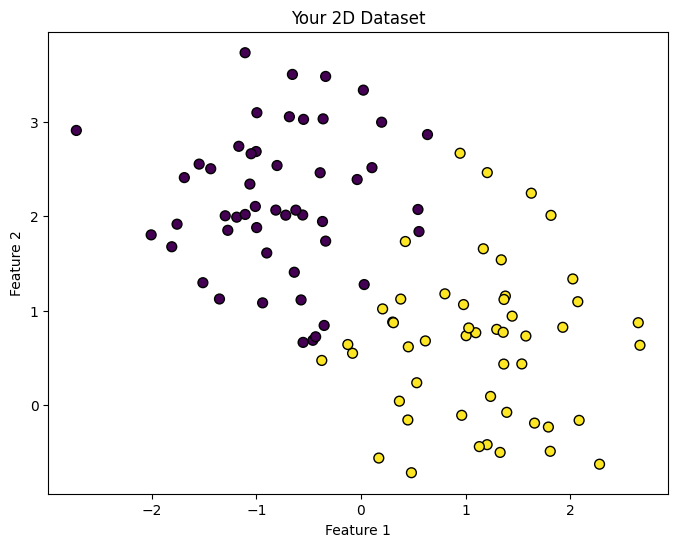

In [3]:
# Plot the 2D classification data
plot_graph(X, y)

Let us perform the usual machine learning pipeline to infer the test accuracy over the **entire** test set using Logistic Regression (LR). You may change the classifier.

In [4]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Array of indices
indices = np.arange(X.shape[0])

# Split the indices
train_indices, test_indices = train_test_split(indices, test_size=0.3, random_state=42)

# Split the data using the indices
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train a classifier over the data
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy over the test set
accuracy_test = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test set: {accuracy_test:.4f}')


Accuracy on the test set: 0.9333


Let us highlight the test set on the graph. It will be important to manage the possible changes on it.

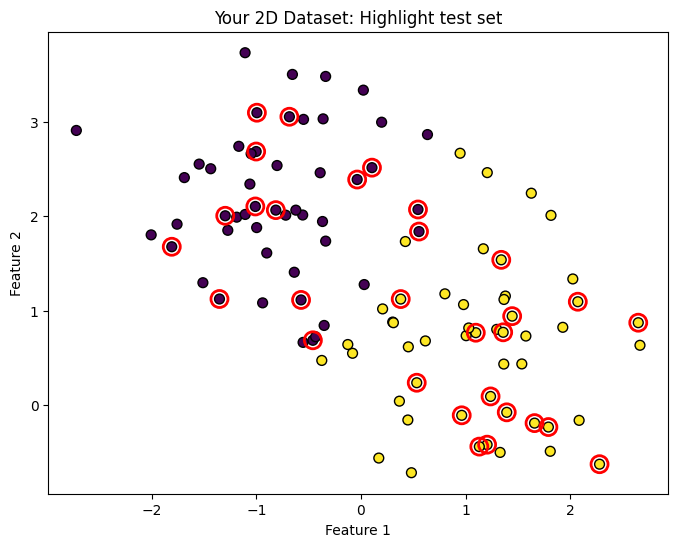

In [5]:
# Highlight the test set on the plot
plot_highlight_test_set(X, y, test_indices=test_indices)

Let us maintain just the test set on the graph with a (very!) small index per point for tracking.

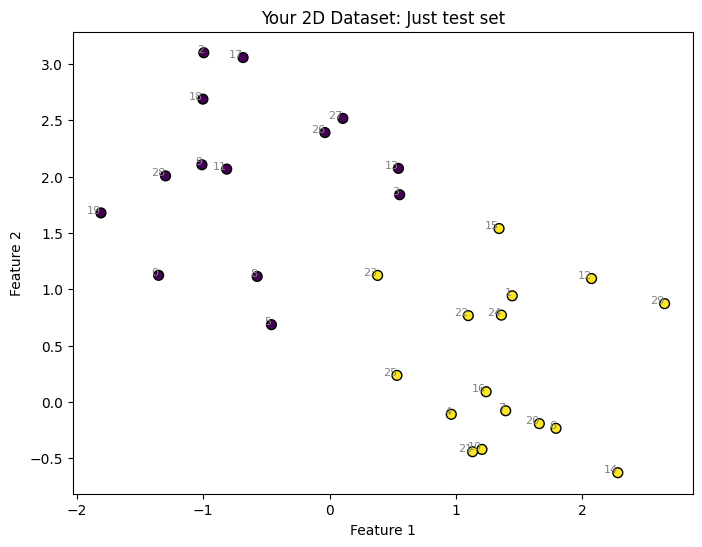

In [6]:
# Plot test set with index
plot_just_test_set(X_test, y_test)

Let us now plot y_test and y_pred together in the same graph. The values of y_pred (shaded circles) are shifted vertically by a small amount to allow better visualization. It is possible to see where the classifier uncorrectedly classified the true labels **by the different collors** between y_test and y_pred.

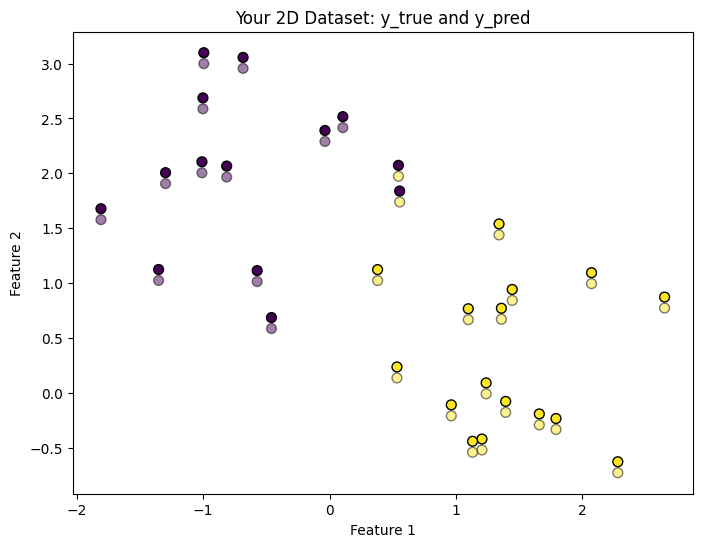

In [7]:
# Plot y_test and y_pred simultaneously
plot_ytest_ypred(X_test, y_test, y_pred)

Let us now analyze the neighborhood of a list of selected points in the test set.

Accuracy on the reduced test set of Sample 16 and its nearest neighbors: 100.0%


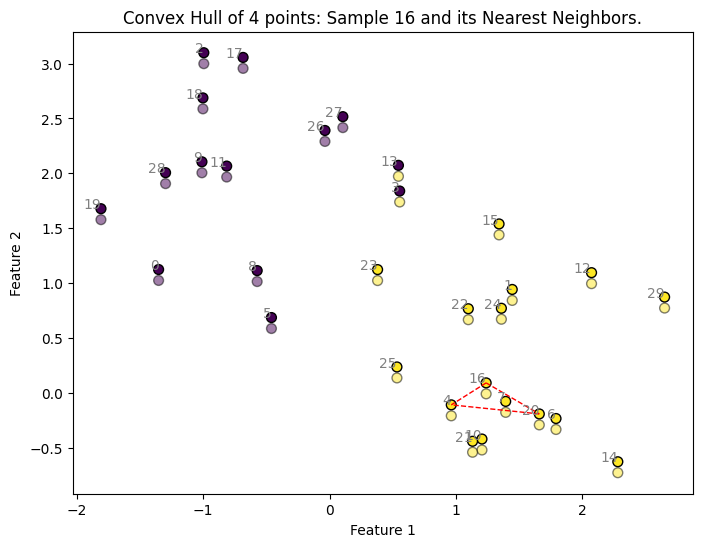

Accuracy on the reduced test set of Sample 25 and its nearest neighbors: 100.0%


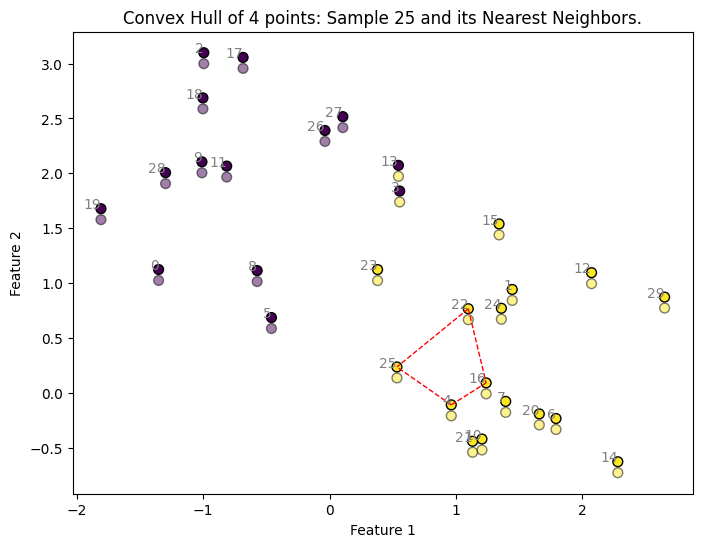

Accuracy on the reduced test set of Sample 13 and its nearest neighbors: 50.0%


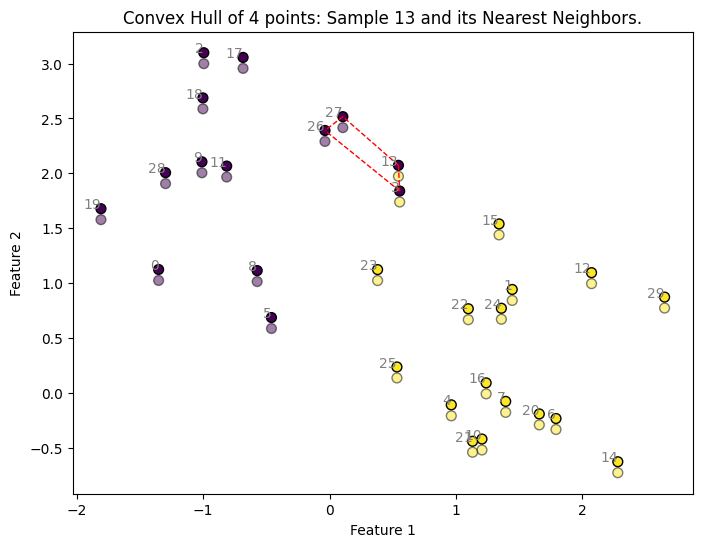

In [8]:
# Choose the size of the neighborhood
n_neighbors = 4

# Choose the points of interest
points_of_interest = [16, 25, 13]

# Plot points of interest and its neighborhoods
plot_neighborhoods(X_test, y_test, y_pred, n_neighbors, points_of_interest)

Check if the accuracies calculated in each convex hull composed of the point of interest and its neighborhood have the same value. Empirical experiments on different synthetic and real datasets have showed that these values were not the same when varying *points_of_interest* or *n_neighbors*. You have probably observed the same. **Why does it happen?** Because the dataset has its own nuances in its topology, which cause the local accuracies, considering only the neighborhoods of the points of interest, to be different.

At this point, we propose the **accuracy degradation profile (ADP)**, a method to evaluate the **robustness** of machine learning models on datasets by iteratively **reducing the test set size** and analyzing the impact on accuracy. ADP points out on each portions (of the reduced dataset) the mean accuracy over each sample considering its neighborhoods falls dows over a defined threshold. APD is clearly understandable by an example.

Let us perform ADP over the selected dataset:

In [9]:
# Perform accuracy degradation profile (ADP)
results = accuracy_degradation_profile(X_test, 
                                       y_test, 
                                       y_pred, 
                                       n_neighbors = 4, 
                                       baseline_accuracy = accuracy_test,
                                       )
results

/home/andrelfnovaes/holisticai/holisticai/src/holisticai/robustness/dataset_shift/_accuracy_degradation_profile.py:287: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary_df = pd.concat([results_summary_df, new_row], ignore_index=True)


,size_factor,above_threshold,percent_above,decision
1,0.950000,30,1.000000,OK
2,0.900000,30,1.000000,OK
3,0.850000,30,1.000000,OK
4,0.800000,30,1.000000,OK
5,0.750000,30,1.000000,OK
6,0.700000,30,1.000000,OK
7,0.650000,30,1.000000,OK
8,0.600000,30,1.000000,OK
9,0.550000,13,0.433333,acc degrad!
10,0.500000,15,0.500000,acc degrad!


Understanding the ADP profile matrix, column-by-column:

- **size_factor** is the proportion of the test set that is being considered. If e.g. **size_factor** = 0.95, all samples of the test set are considering just the 95% nearest neighboors for accuracy calculation.

- **above_threshold** is the number of samples with accuracy above the *threshold*. The variable *threshold* is the minimum acceptable accuracy, calculated as *baseline_accuracy* * *threshold_percentual*, with the second term being the threshold percentage for accuracy degradation. If e.g. **above_threshold** = 30, then 30 samples of the test set showed its accuracy (calculated over its neighboorhood) above the minimum acceptable accuracy. Default value for *threshold_percentual*: 0.95.

- **percent_above** is the proportion of samples with accuracy above the *threshold*. If e.g. **percent_above** = 1.0, then 100% of samples of the test set showed its accuracy (calculated over its neighboorhood) above the minimum acceptable accuracy.

- **decision** is the result of *above_threshold* compared with *above_percentual*, with the second term being the percentage of samples required to be above the threshold to avoid degradation. If *above_threshold* is greater than or equal to *above_percentual*, then there is no accuracy degradation (marked as 'OK').  If *above_threshold* is smaller than *above_percentual*, then there is accuracy degradation (marked as 'acc degrad!'). Default value for *above_percentual*: 0.90.

**Summary**:

Every time you see 'acc degrad!' on the ADP matrix, **watch out** (!!!): *the mean accuracy over the convex hulls (samples and its neighboorhood) are not superior than than the minimum acceptable accuracy*. It may be valuable to look deeper on the topology of the dataset to check what is actually happening with your classifier applied to the reduced dataset. Even if your dataset is multidimensional, you may use dimensionality reduction to look at it in 2D.

Let us now use ADP in **real datasets:**

(You can import your own dataset)

In [10]:
from holisticai.datasets import load_dataset

# Choose any of the following datasets:
# 'adult'
# 'law_school'
# 'student_multiclass'
# 'us_crime_multiclass'
# 'clinical_records'

# Load dataset
dataset = load_dataset('law_school')

# Select only the first n rows (recommended if the dataset has ~10,000 rows or more) 
first_n_rows=1000
X = dataset['X'].iloc[:first_n_rows,:]
y = dataset['y'].iloc[:first_n_rows]



In [11]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)

In [12]:
# Train a classifier over the data
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy over the entire test set
accuracy_test = accuracy_score(y_test, y_pred)

/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
# Perform accuracy degradation profile (ADP)
results = accuracy_degradation_profile(X_test, 
                                       y_test, 
                                       y_pred, 
                                       n_neighbors = 4, 
                                       baseline_accuracy = accuracy_test,
                                       )
results


/home/andrelfnovaes/holisticai/holisticai/src/holisticai/robustness/dataset_shift/_accuracy_degradation_profile.py:287: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary_df = pd.concat([results_summary_df, new_row], ignore_index=True)


,size_factor,above_threshold,percent_above,decision
1,0.950000,300,1.000000,OK
2,0.900000,300,1.000000,OK
3,0.850000,300,1.000000,OK
4,0.800000,300,1.000000,OK
5,0.750000,300,1.000000,OK
6,0.700000,300,1.000000,OK
7,0.650000,300,1.000000,OK
8,0.600000,300,1.000000,OK
9,0.550000,300,1.000000,OK
10,0.500000,300,1.000000,OK
